# Практическая работа 6: Программирование на OpenCL для CPU и GPU
Задача №1.
1. Подготовка окружения:
1. Установите необходимые драйверы для OpenCL на вашей системе.
a. Для CPU: установите драйверы от производителя процессора
(Intel, AMD).
b. Для GPU: установите драйверы от производителя видеокарты
(NVIDIA, AMD).
2. Убедитесь, что OpenCL-библиотеки доступны в вашей системе:
a. Linux: /usr/lib/libOpenCL.so
b. Windows: OpenCL.dll
3. Настройте среду разработки (например, VS Code, CLion или Visual
Studio).


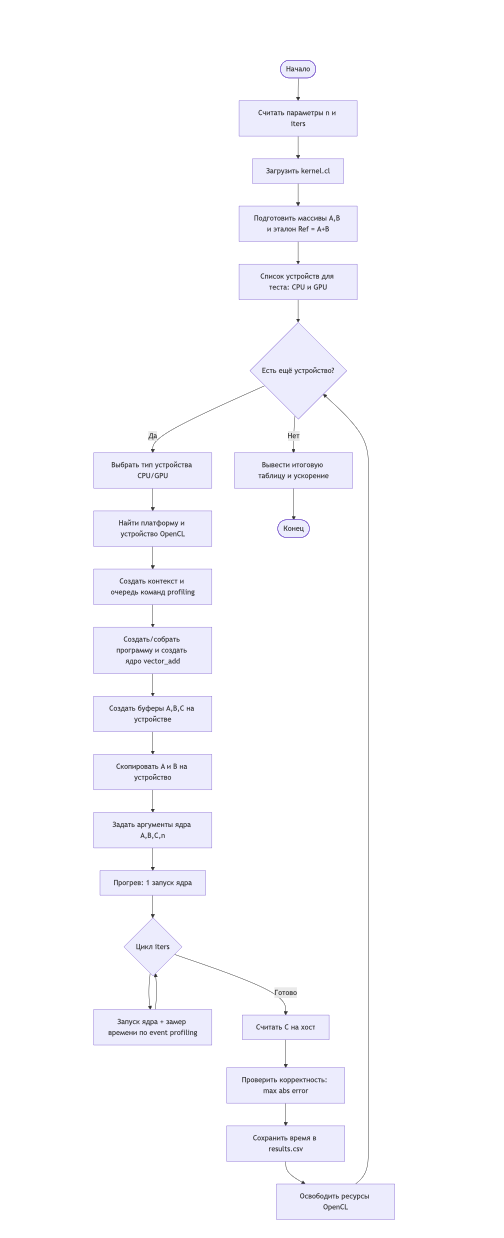

In [2]:
!apt-get update -y
!apt-get install -y ocl-icd-opencl-dev clinfo pocl-opencl-icd g++
!clinfo | head -n 80

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,297 kB]
Get:6 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,867 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,205 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-dr

In [4]:
%%writefile kernel.cl
__kernel void vector_add(__global const float* A,
                         __global const float* B,
                         __global float* C,
                         const int n)
{
    int id = get_global_id(0);
    if (id < n) C[id] = A[id] + B[id];
}


Overwriting kernel.cl


In [5]:
%%writefile vector_add.cpp
// ------------------------------------------------------------
// Лабораторная работа: OpenCL Vector Add (A + B = C)
// Среда: Google Colab (CPU: POCL, GPU: NVIDIA CUDA OpenCL)
// Автор: (впиши своё ФИО)
// ------------------------------------------------------------

#define CL_TARGET_OPENCL_VERSION 120   // Указываем целевую версию OpenCL (1.2 достаточно для базовых задач)
#include <CL/cl.h>

#include <cmath>      // sin/cos для генерации данных
#include <cstdlib>    // atoi, exit
#include <fstream>    // чтение kernel.cl
#include <iostream>   // вывод в консоль
#include <string>
#include <vector>     // массивы на хосте
#include <algorithm>  // max

// Простая функция проверки ошибок OpenCL.
// Если ошибка != CL_SUCCESS, выводим сообщение и завершаем программу.
static void check(cl_int err, const char* msg) {
    if (err != CL_SUCCESS) {
        std::cerr << "OpenCL error: " << msg << " (code " << err << ")\n";
        std::exit(1);
    }
}

// Читаем исходник OpenCL ядра из файла (kernel.cl) в строку.
static std::string loadTextFile(const std::string& path) {
    std::ifstream f(path);
    if (!f) {
        std::cerr << "Cannot open file: " << path << "\n";
        std::exit(1);
    }
    return std::string((std::istreambuf_iterator<char>(f)), std::istreambuf_iterator<char>());
}

// Получаем имя платформы OpenCL (например, "NVIDIA CUDA" или "Portable Computing Language").
static std::string getPlatformName(cl_platform_id p) {
    size_t sz = 0;
    clGetPlatformInfo(p, CL_PLATFORM_NAME, 0, nullptr, &sz);
    std::string s(sz, '\0');
    clGetPlatformInfo(p, CL_PLATFORM_NAME, sz, s.data(), nullptr);
    while (!s.empty() && (s.back()=='\0' || s.back()=='\n' || s.back()=='\r')) s.pop_back();
    return s;
}

// Получаем имя устройства OpenCL (например, "Tesla T4" или "pthread-Intel Xeon ...").
static std::string getDeviceName(cl_device_id d) {
    size_t sz = 0;
    clGetDeviceInfo(d, CL_DEVICE_NAME, 0, nullptr, &sz);
    std::string s(sz, '\0');
    clGetDeviceInfo(d, CL_DEVICE_NAME, sz, s.data(), nullptr);
    while (!s.empty() && (s.back()=='\0' || s.back()=='\n' || s.back()=='\r')) s.pop_back();
    return s;
}

// Выбор устройства.
// Для GPU стараемся сначала найти NVIDIA (в Colab это Tesla T4).
// Для CPU берём первое доступное CPU-устройство (обычно POCL).
static bool pickDevicePreferNvidiaGPU(cl_device_type typeWanted,
                                      cl_platform_id& outPlatform,
                                      cl_device_id& outDevice) {
    cl_uint numPlatforms = 0;
    if (clGetPlatformIDs(0, nullptr, &numPlatforms) != CL_SUCCESS || numPlatforms == 0) return false;

    std::vector<cl_platform_id> platforms(numPlatforms);
    check(clGetPlatformIDs(numPlatforms, platforms.data(), nullptr), "clGetPlatformIDs");

    // Если хотим GPU — пробуем сначала платформу NVIDIA.
    if (typeWanted == CL_DEVICE_TYPE_GPU) {
        for (auto p : platforms) {
            std::string pname = getPlatformName(p);
            if (pname.find("NVIDIA") == std::string::npos) continue;

            cl_uint numDev = 0;
            cl_int err = clGetDeviceIDs(p, CL_DEVICE_TYPE_GPU, 0, nullptr, &numDev);
            if (err != CL_SUCCESS || numDev == 0) continue;

            std::vector<cl_device_id> devs(numDev);
            check(clGetDeviceIDs(p, CL_DEVICE_TYPE_GPU, numDev, devs.data(), nullptr),
                  "clGetDeviceIDs(NVIDIA GPU)");
            outPlatform = p;
            outDevice = devs[0];   // берём первое GPU-устройство
            return true;
        }
    }

    // Если NVIDIA не нашли или нам нужен CPU — берём первое устройство нужного типа.
    for (auto p : platforms) {
        cl_uint numDev = 0;
        cl_int err = clGetDeviceIDs(p, typeWanted, 0, nullptr, &numDev);
        if (err != CL_SUCCESS || numDev == 0) continue;

        std::vector<cl_device_id> devs(numDev);
        check(clGetDeviceIDs(p, typeWanted, numDev, devs.data(), nullptr), "clGetDeviceIDs(general)");
        outPlatform = p;
        outDevice = devs[0];
        return true;
    }

    return false;
}

// Основная функция запуска OpenCL ядра vector_add на выбранном типе устройства (CPU или GPU).
// Возвращает среднее время ядра (kernel time) в миллисекундах.
static double runVectorAdd(cl_device_type devType, int n, int iters,
                           const std::string& kernelPath, const std::string& tag) {
    cl_platform_id platform = nullptr;
    cl_device_id device = nullptr;

    // Выбираем платформу + устройство
    if (!pickDevicePreferNvidiaGPU(devType, platform, device)) {
        std::cerr << "[" << tag << "] No device found.\n";
        return -1.0;
    }

    // Для отчёта выводим, где именно запустились
    std::cout << "\n=== " << tag << " ===\n";
    std::cout << "Platform: " << getPlatformName(platform) << "\n";
    std::cout << "Device:   " << getDeviceName(device) << "\n";

    cl_int err = CL_SUCCESS;

    // Создаём контекст OpenCL для выбранного устройства
    cl_context context = clCreateContext(nullptr, 1, &device, nullptr, nullptr, &err);
    check(err, "clCreateContext");

    // Создаём очередь команд с включённым профилированием (чтобы замерять время ядра)
    cl_command_queue queue = clCreateCommandQueue(context, device, CL_QUEUE_PROFILING_ENABLE, &err);
    check(err, "clCreateCommandQueue");

    // Загружаем исходник ядра из kernel.cl
    std::string src = loadTextFile(kernelPath);
    const char* srcPtr = src.c_str();
    size_t srcLen = src.size();

    // Создаём OpenCL program из текста
    cl_program program = clCreateProgramWithSource(context, 1, &srcPtr, &srcLen, &err);
    check(err, "clCreateProgramWithSource");

    // Компилируем program для устройства
    err = clBuildProgram(program, 1, &device, nullptr, nullptr, nullptr);
    if (err != CL_SUCCESS) {
        // Если компиляция не прошла — печатаем лог
        size_t logSize = 0;
        clGetProgramBuildInfo(program, device, CL_PROGRAM_BUILD_LOG, 0, nullptr, &logSize);
        std::string log(logSize, '\0');
        clGetProgramBuildInfo(program, device, CL_PROGRAM_BUILD_LOG, logSize, log.data(), nullptr);
        std::cerr << "Build log:\n" << log << "\n";
        check(err, "clBuildProgram");
    }

    // Получаем объект kernel по имени функции из kernel.cl
    cl_kernel kernel = clCreateKernel(program, "vector_add", &err);
    check(err, "clCreateKernel");

    // ----------------------------
    // 1) Подготовка данных на CPU (host)
    // ----------------------------
    std::vector<float> A(n), B(n), C(n, 0.0f), Ref(n);
    for (int i = 0; i < n; i++) {
        A[i] = std::sin(i * 0.001f);
        B[i] = std::cos(i * 0.001f);
        Ref[i] = A[i] + B[i]; // эталон для проверки корректности
    }

    // ----------------------------
    // 2) Буферы на устройстве (device buffers)
    // ----------------------------
    cl_mem bufA = clCreateBuffer(context, CL_MEM_READ_ONLY,  sizeof(float) * n, nullptr, &err);
    check(err, "clCreateBuffer(A)");
    cl_mem bufB = clCreateBuffer(context, CL_MEM_READ_ONLY,  sizeof(float) * n, nullptr, &err);
    check(err, "clCreateBuffer(B)");
    cl_mem bufC = clCreateBuffer(context, CL_MEM_WRITE_ONLY, sizeof(float) * n, nullptr, &err);
    check(err, "clCreateBuffer(C)");

    // Копируем A и B на устройство
    check(clEnqueueWriteBuffer(queue, bufA, CL_TRUE, 0, sizeof(float) * n, A.data(), 0, nullptr, nullptr),
          "write(A)");
    check(clEnqueueWriteBuffer(queue, bufB, CL_TRUE, 0, sizeof(float) * n, B.data(), 0, nullptr, nullptr),
          "write(B)");

    // ----------------------------
    // 3) Передаём аргументы в ядро
    // ----------------------------
    check(clSetKernelArg(kernel, 0, sizeof(cl_mem), &bufA), "arg0(A)");
    check(clSetKernelArg(kernel, 1, sizeof(cl_mem), &bufB), "arg1(B)");
    check(clSetKernelArg(kernel, 2, sizeof(cl_mem), &bufC), "arg2(C)");
    check(clSetKernelArg(kernel, 3, sizeof(int), &n),       "arg3(n)");

    // ----------------------------
    // 4) Настройка глобального размера (1D)
    // Глобальный размер = количество элементов n
    // ----------------------------
    size_t global = static_cast<size_t>(n);

    // Прогрев (warmup): один запуск без учёта времени (чтобы стабилизировать замер)
    {
        cl_event eWarm = nullptr;
        check(clEnqueueNDRangeKernel(queue, kernel, 1, nullptr, &global, nullptr, 0, nullptr, &eWarm),
              "kernel(warmup)");
        clWaitForEvents(1, &eWarm);
        clReleaseEvent(eWarm);
    }

    // ----------------------------
    // 5) Основные замеры времени ядра (iters запусков)
    // Время берём из event profiling: START/END
    // ----------------------------
    double totalKernelMs = 0.0;
    for (int i = 0; i < iters; i++) {
        cl_event e = nullptr;
        check(clEnqueueNDRangeKernel(queue, kernel, 1, nullptr, &global, nullptr, 0, nullptr, &e),
              "kernel");
        clWaitForEvents(1, &e);

        cl_ulong start = 0, end = 0;
        check(clGetEventProfilingInfo(e, CL_PROFILING_COMMAND_START, sizeof(cl_ulong), &start, nullptr),
              "profiling(start)");
        check(clGetEventProfilingInfo(e, CL_PROFILING_COMMAND_END, sizeof(cl_ulong), &end, nullptr),
              "profiling(end)");

        // nanoseconds -> milliseconds
        totalKernelMs += (double)(end - start) * 1e-6;

        clReleaseEvent(e);
    }

    // Считываем результат C с устройства на CPU
    check(clEnqueueReadBuffer(queue, bufC, CL_TRUE, 0, sizeof(float) * n, C.data(), 0, nullptr, nullptr),
          "read(C)");

    // ----------------------------
    // 6) Проверка корректности
    // ----------------------------
    double maxAbsErr = 0.0;
    for (int i = 0; i < n; i++) {
        maxAbsErr = std::max(maxAbsErr, std::abs((double)C[i] - (double)Ref[i]));
    }
    std::cout << "Max abs error: " << maxAbsErr << "\n";

    // Среднее время ядра
    double avgKernelMs = totalKernelMs / iters;
    std::cout << "Avg kernel time: " << avgKernelMs << " ms\n";

    // ----------------------------
    // 7) Очистка ресурсов OpenCL
    // ----------------------------
    clReleaseMemObject(bufA);
    clReleaseMemObject(bufB);
    clReleaseMemObject(bufC);
    clReleaseKernel(kernel);
    clReleaseProgram(program);
    clReleaseCommandQueue(queue);
    clReleaseContext(context);

    return avgKernelMs;
}

int main(int argc, char** argv) {
    // Размер вектора и количество итераций можно задать аргументами командной строки
    // Пример: ./vec_add 16777216 50
    int n     = (argc >= 2) ? std::atoi(argv[1]) : (1 << 24); // по умолчанию ~16M
    int iters = (argc >= 3) ? std::atoi(argv[2]) : 50;

    std::cout << "Vector size n=" << n << ", iters=" << iters << "\n";

    // Запуск на CPU и GPU
    double cpuMs = runVectorAdd(CL_DEVICE_TYPE_CPU, n, iters, "kernel.cl", "CPU(OpenCL)");
    double gpuMs = runVectorAdd(CL_DEVICE_TYPE_GPU, n, iters, "kernel.cl", "GPU(OpenCL)");

    // Сохраняем результат в CSV (для построения графика)
    std::ofstream out("results.csv");
    out << "device,avg_kernel_ms\n";
    if (cpuMs > 0) out << "CPU," << cpuMs << "\n";
    if (gpuMs > 0) out << "GPU," << gpuMs << "\n";
    out.close();

    // Итоговый вывод
    std::cout << "\n===== Summary =====\n";
    std::cout << "CPU avg kernel time: " << cpuMs << " ms\n";
    std::cout << "GPU avg kernel time: " << gpuMs << " ms\n";
    if (cpuMs > 0 && gpuMs > 0) {
        std::cout << "Speedup (CPU/GPU): " << (cpuMs / gpuMs) << "x\n";
    }
    std::cout << "Saved results.csv\n";

    return 0;
}


Overwriting vector_add.cpp


In [6]:
!g++ vector_add.cpp -O2 -lOpenCL -o vec_add
!./vec_add 16777216 50


Vector size n=16777216, iters=50

=== CPU(OpenCL) ===
Platform: Portable Computing Language
Device:   pthread-Intel(R) Xeon(R) CPU @ 2.20GHz
Max abs error: 0
Avg kernel time: 14.5889 ms

=== GPU(OpenCL) ===
Platform: NVIDIA CUDA
Device:   Tesla T4
Max abs error: 0
Avg kernel time: 0.772614 ms

===== Summary =====
CPU avg kernel time: 14.5889 ms
GPU avg kernel time: 0.772614 ms
Speedup (CPU/GPU): 18.8826x
Saved results.csv


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results.csv")
df


,device,avg_kernel_ms
0,CPU,14.588900
1,GPU,0.772614


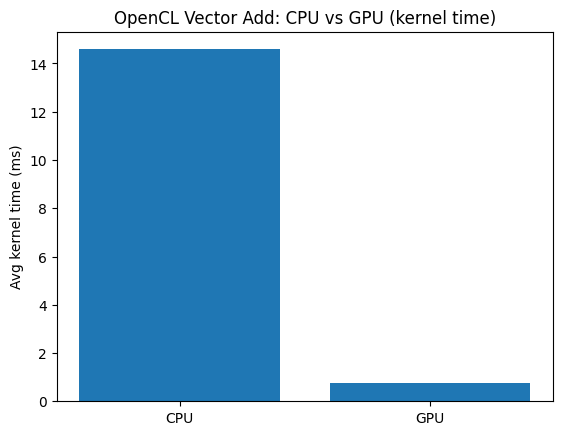

In [8]:
plt.figure()
plt.bar(df["device"], df["avg_kernel_ms"])
plt.ylabel("Avg kernel time (ms)")
plt.title("OpenCL Vector Add: CPU vs GPU (kernel time)")
plt.show()


Задача №2.
Описание задачи:
Реализуйте программу для параллельного умножения двух матриц с
использованием OpenCL. Матрицы A и B имеют размеры N×M и M×K
соответственно. Программа должна вычислить результирующую матрицу C
размером N×K.

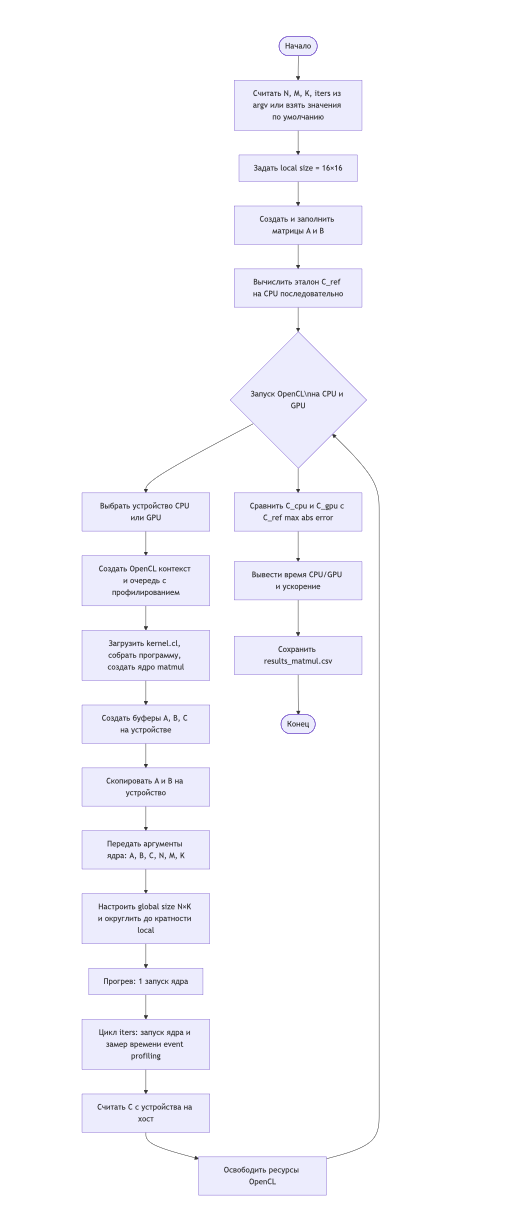

In [9]:
%%writefile kernel.cl
__kernel void matmul(__global const float* A,
                     __global const float* B,
                     __global float* C,
                     const int N, const int M, const int K)
{
    // C is N x K
    int row = get_global_id(0);
    int col = get_global_id(1);

    if (row < N && col < K) {
        float sum = 0.0f;
        for (int i = 0; i < M; i++) {
            sum += A[row * M + i] * B[i * K + col];
        }
        C[row * K + col] = sum;
    }
}


Overwriting kernel.cl


In [10]:
%%writefile matmul.cpp
// ------------------------------------------------------------
// Лабораторная работа: OpenCL Matrix Multiplication (C = A * B)
// A: N×M, B: M×K, C: N×K
// Среда: Google Colab (CPU: POCL, GPU: NVIDIA CUDA OpenCL)
// Автор: (впиши своё ФИО)
// ------------------------------------------------------------

#define CL_TARGET_OPENCL_VERSION 120   // Целевая версия OpenCL (1.2 хватает для базового кода)
#include <CL/cl.h>

#include <algorithm>   // max
#include <cmath>       // sin/cos для генерации чисел
#include <cstdlib>     // atoi, exit
#include <fstream>     // чтение kernel.cl
#include <iostream>    // вывод
#include <string>
#include <vector>      // массивы на хосте

// Проверка ошибок OpenCL: если err != CL_SUCCESS, печатаем и выходим
static void check(cl_int err, const char* msg) {
    if (err != CL_SUCCESS) {
        std::cerr << "OpenCL error: " << msg << " (code " << err << ")\n";
        std::exit(1);
    }
}

// Чтение текста ядра из файла kernel.cl
static std::string loadTextFile(const std::string& path) {
    std::ifstream f(path);
    if (!f) {
        std::cerr << "Cannot open file: " << path << "\n";
        std::exit(1);
    }
    return std::string((std::istreambuf_iterator<char>(f)), std::istreambuf_iterator<char>());
}

// Имя платформы OpenCL (например, "NVIDIA CUDA" или "Portable Computing Language")
static std::string getPlatformName(cl_platform_id p) {
    size_t sz = 0;
    clGetPlatformInfo(p, CL_PLATFORM_NAME, 0, nullptr, &sz);
    std::string s(sz, '\0');
    clGetPlatformInfo(p, CL_PLATFORM_NAME, sz, s.data(), nullptr);
    while (!s.empty() && (s.back()=='\0' || s.back()=='\n' || s.back()=='\r')) s.pop_back();
    return s;
}

// Имя устройства OpenCL (например, "Tesla T4" или "pthread-Intel Xeon ...")
static std::string getDeviceName(cl_device_id d) {
    size_t sz = 0;
    clGetDeviceInfo(d, CL_DEVICE_NAME, 0, nullptr, &sz);
    std::string s(sz, '\0');
    clGetDeviceInfo(d, CL_DEVICE_NAME, sz, s.data(), nullptr);
    while (!s.empty() && (s.back()=='\0' || s.back()=='\n' || s.back()=='\r')) s.pop_back();
    return s;
}

// Выбор устройства:
// - если требуется GPU, то сначала пытаемся найти NVIDIA (в Colab обычно Tesla T4)
// - иначе берём первое доступное устройство нужного типа
static bool pickDevicePreferNvidiaGPU(cl_device_type typeWanted,
                                      cl_platform_id& outPlatform,
                                      cl_device_id& outDevice) {
    cl_uint numPlatforms = 0;
    if (clGetPlatformIDs(0, nullptr, &numPlatforms) != CL_SUCCESS || numPlatforms == 0) return false;

    std::vector<cl_platform_id> platforms(numPlatforms);
    check(clGetPlatformIDs(numPlatforms, platforms.data(), nullptr), "clGetPlatformIDs");

    // Сначала ищем NVIDIA GPU, если пользователь запросил GPU
    if (typeWanted == CL_DEVICE_TYPE_GPU) {
        for (auto p : platforms) {
            std::string pname = getPlatformName(p);
            if (pname.find("NVIDIA") == std::string::npos) continue;

            cl_uint numDev = 0;
            cl_int err = clGetDeviceIDs(p, CL_DEVICE_TYPE_GPU, 0, nullptr, &numDev);
            if (err != CL_SUCCESS || numDev == 0) continue;

            std::vector<cl_device_id> devs(numDev);
            check(clGetDeviceIDs(p, CL_DEVICE_TYPE_GPU, numDev, devs.data(), nullptr),
                  "clGetDeviceIDs(NVIDIA GPU)");
            outPlatform = p;
            outDevice = devs[0]; // берём первое GPU-устройство
            return true;
        }
    }

    // Если NVIDIA не нашли или нужен CPU — берём первое устройство нужного типа
    for (auto p : platforms) {
        cl_uint numDev = 0;
        cl_int err = clGetDeviceIDs(p, typeWanted, 0, nullptr, &numDev);
        if (err != CL_SUCCESS || numDev == 0) continue;

        std::vector<cl_device_id> devs(numDev);
        check(clGetDeviceIDs(p, typeWanted, numDev, devs.data(), nullptr), "clGetDeviceIDs(general)");
        outPlatform = p;
        outDevice = devs[0];
        return true;
    }

    return false;
}

// Последовательная (CPU) эталонная реализация матричного умножения:
// Cref = A(NxM) * B(MxK)
static void matmul_cpu_ref(const std::vector<float>& A,
                           const std::vector<float>& B,
                           std::vector<float>& Cref,
                           int N, int M, int K) {
    for (int r = 0; r < N; r++) {
        for (int c = 0; c < K; c++) {
            double sum = 0.0; // используем double для более стабильного суммирования
            for (int i = 0; i < M; i++) {
                sum += (double)A[r * M + i] * (double)B[i * K + c];
            }
            Cref[r * K + c] = (float)sum;
        }
    }
}

// Запуск OpenCL matmul на CPU или GPU.
// Возвращаем среднее время выполнения ядра (kernel time) в миллисекундах.
static double run_opencl_matmul(cl_device_type devType,
                                const std::vector<float>& A,
                                const std::vector<float>& B,
                                std::vector<float>& C,
                                int N, int M, int K,
                                int iters,
                                const std::string& kernelPath,
                                const std::string& tag,
                                size_t local0, size_t local1) {
    cl_platform_id platform = nullptr;
    cl_device_id device = nullptr;

    // Выбираем устройство
    if (!pickDevicePreferNvidiaGPU(devType, platform, device)) {
        std::cerr << "[" << tag << "] No device found.\n";
        return -1.0;
    }

    // Информация для отчёта: на каком устройстве запустилось
    std::cout << "\n=== " << tag << " ===\n";
    std::cout << "Platform: " << getPlatformName(platform) << "\n";
    std::cout << "Device:   " << getDeviceName(device) << "\n";
    std::cout << "Local size: (" << local0 << ", " << local1 << ")\n";

    cl_int err = CL_SUCCESS;

    // Создаём контекст OpenCL
    cl_context context = clCreateContext(nullptr, 1, &device, nullptr, nullptr, &err);
    check(err, "clCreateContext");

    // Очередь команд с профилированием (чтобы получить время ядра через события)
    cl_command_queue queue = clCreateCommandQueue(context, device, CL_QUEUE_PROFILING_ENABLE, &err);
    check(err, "clCreateCommandQueue");

    // Загружаем kernel.cl
    std::string src = loadTextFile(kernelPath);
    const char* srcPtr = src.c_str();
    size_t srcLen = src.size();

    // Создаём программу OpenCL из исходника
    cl_program program = clCreateProgramWithSource(context, 1, &srcPtr, &srcLen, &err);
    check(err, "clCreateProgramWithSource");

    // Компилируем программу (build)
    err = clBuildProgram(program, 1, &device, nullptr, nullptr, nullptr);
    if (err != CL_SUCCESS) {
        // Если ошибка — печатаем build log
        size_t logSize = 0;
        clGetProgramBuildInfo(program, device, CL_PROGRAM_BUILD_LOG, 0, nullptr, &logSize);
        std::string log(logSize, '\0');
        clGetProgramBuildInfo(program, device, CL_PROGRAM_BUILD_LOG, logSize, log.data(), nullptr);
        std::cerr << "Build log:\n" << log << "\n";
        check(err, "clBuildProgram");
    }

    // Получаем kernel по имени "matmul" из kernel.cl
    cl_kernel kernel = clCreateKernel(program, "matmul", &err);
    check(err, "clCreateKernel");

    // Считаем размеры буферов в байтах
    size_t bytesA = sizeof(float) * (size_t)N * (size_t)M;
    size_t bytesB = sizeof(float) * (size_t)M * (size_t)K;
    size_t bytesC = sizeof(float) * (size_t)N * (size_t)K;

    // Создаём буферы на устройстве
    cl_mem bufA = clCreateBuffer(context, CL_MEM_READ_ONLY,  bytesA, nullptr, &err);
    check(err, "clCreateBuffer(A)");
    cl_mem bufB = clCreateBuffer(context, CL_MEM_READ_ONLY,  bytesB, nullptr, &err);
    check(err, "clCreateBuffer(B)");
    cl_mem bufC = clCreateBuffer(context, CL_MEM_WRITE_ONLY, bytesC, nullptr, &err);
    check(err, "clCreateBuffer(C)");

    // Копируем A и B на устройство (host -> device)
    check(clEnqueueWriteBuffer(queue, bufA, CL_TRUE, 0, bytesA, A.data(), 0, nullptr, nullptr), "write(A)");
    check(clEnqueueWriteBuffer(queue, bufB, CL_TRUE, 0, bytesB, B.data(), 0, nullptr, nullptr), "write(B)");

    // Передаём аргументы в kernel:
    // kernel(A, B, C, N, M, K)
    check(clSetKernelArg(kernel, 0, sizeof(cl_mem), &bufA), "arg0(A)");
    check(clSetKernelArg(kernel, 1, sizeof(cl_mem), &bufB), "arg1(B)");
    check(clSetKernelArg(kernel, 2, sizeof(cl_mem), &bufC), "arg2(C)");
    check(clSetKernelArg(kernel, 3, sizeof(int), &N), "arg3(N)");
    check(clSetKernelArg(kernel, 4, sizeof(int), &M), "arg4(M)");
    check(clSetKernelArg(kernel, 5, sizeof(int), &K), "arg5(K)");

    // ----------------------------
    // Настройка NDRange:
    // C имеет размер N x K => запускаем 2D сетку (row, col)
    // global = (N, K), но округляем вверх до кратности local size
    // ----------------------------
    auto roundUp = [](size_t x, size_t m) {
        return ((x + m - 1) / m) * m;
    };

    size_t global0 = roundUp((size_t)N, local0); // по строкам
    size_t global1 = roundUp((size_t)K, local1); // по столбцам

    const size_t global[2] = { global0, global1 };
    const size_t local[2]  = { local0, local1 };

    // Прогревочный запуск (warmup) — чтобы замеры были стабильнее
    {
        cl_event ew = nullptr;
        check(clEnqueueNDRangeKernel(queue, kernel, 2, nullptr, global, local, 0, nullptr, &ew), "kernel(warmup)");
        clWaitForEvents(1, &ew);
        clReleaseEvent(ew);
    }

    // Основные замеры времени ядра (iters запусков)
    // Время берём из event profiling (START/END) => kernel-only time
    double totalKernelMs = 0.0;
    for (int i = 0; i < iters; i++) {
        cl_event e = nullptr;
        check(clEnqueueNDRangeKernel(queue, kernel, 2, nullptr, global, local, 0, nullptr, &e), "kernel");
        clWaitForEvents(1, &e);

        cl_ulong start = 0, end = 0;
        check(clGetEventProfilingInfo(e, CL_PROFILING_COMMAND_START, sizeof(cl_ulong), &start, nullptr), "profiling(start)");
        check(clGetEventProfilingInfo(e, CL_PROFILING_COMMAND_END, sizeof(cl_ulong), &end, nullptr), "profiling(end)");
        totalKernelMs += (double)(end - start) * 1e-6; // ns -> ms

        clReleaseEvent(e);
    }

    // Считываем результат C с устройства (device -> host)
    check(clEnqueueReadBuffer(queue, bufC, CL_TRUE, 0, bytesC, C.data(), 0, nullptr, nullptr), "read(C)");

    // Среднее время ядра
    double avgKernelMs = totalKernelMs / iters;
    std::cout << "Avg kernel time: " << avgKernelMs << " ms (iters=" << iters << ")\n";

    // Освобождаем ресурсы OpenCL
    clReleaseMemObject(bufA);
    clReleaseMemObject(bufB);
    clReleaseMemObject(bufC);
    clReleaseKernel(kernel);
    clReleaseProgram(program);
    clReleaseCommandQueue(queue);
    clReleaseContext(context);

    return avgKernelMs;
}

int main(int argc, char** argv) {
    // Размеры матриц можно задавать аргументами:
    // ./matmul N M K iters
    int N = (argc >= 2) ? std::atoi(argv[1]) : 512;
    int M = (argc >= 3) ? std::atoi(argv[2]) : 512;
    int K = (argc >= 4) ? std::atoi(argv[3]) : 512;
    int iters = (argc >= 5) ? std::atoi(argv[4]) : 10;

    // Локальный размер (work-group). 16x16 — стандартная базовая настройка для GPU
    size_t local0 = 16, local1 = 16;

    std::cout << "Matrix sizes: A=" << N << "x" << M
              << ", B=" << M << "x" << K
              << ", C=" << N << "x" << K
              << ", iters=" << iters << "\n";

    // ----------------------------
    // Подготовка матриц на хосте
    // ----------------------------
    std::vector<float> A((size_t)N * (size_t)M);
    std::vector<float> B((size_t)M * (size_t)K);
    std::vector<float> Ccpu((size_t)N * (size_t)K, 0.0f);       // результат OpenCL на CPU
    std::vector<float> Ccpu_ref((size_t)N * (size_t)K, 0.0f);   // эталон (последовательный CPU)
    std::vector<float> Cgpu((size_t)N * (size_t)K, 0.0f);       // результат OpenCL на GPU

    // Заполняем A и B детерминированно (чтобы повторяемость результатов была одинаковой)
    for (int i = 0; i < N * M; i++) A[i] = std::sin(i * 0.001f);
    for (int i = 0; i < M * K; i++) B[i] = std::cos(i * 0.001f);

    // ----------------------------
    // Эталонная проверка (последовательный CPU)
    // ----------------------------
    std::cout << "\nComputing CPU reference (sequential)...\n";
    matmul_cpu_ref(A, B, Ccpu_ref, N, M, K);

    // ----------------------------
    // Запуск OpenCL на CPU и на GPU
    // ----------------------------
    double cpuMs = run_opencl_matmul(CL_DEVICE_TYPE_CPU, A, B, Ccpu, N, M, K, iters,
                                     "kernel.cl", "CPU(OpenCL)", local0, local1);
    double gpuMs = run_opencl_matmul(CL_DEVICE_TYPE_GPU, A, B, Cgpu, N, M, K, iters,
                                     "kernel.cl", "GPU(OpenCL)", local0, local1);

    // ----------------------------
    // Проверка корректности: сравниваем с эталоном
    // ----------------------------
    auto maxAbsErr = [](const std::vector<float>& X, const std::vector<float>& Y) {
        double m = 0.0;
        for (size_t i = 0; i < X.size(); i++) {
            m = std::max(m, std::abs((double)X[i] - (double)Y[i]));
        }
        return m;
    };

    double errCPU = maxAbsErr(Ccpu, Ccpu_ref);
    double errGPU = maxAbsErr(Cgpu, Ccpu_ref);

    std::cout << "\n===== Correctness =====\n";
    std::cout << "Max abs error (OpenCL CPU vs ref): " << errCPU << "\n";
    std::cout << "Max abs error (OpenCL GPU vs ref): " << errGPU << "\n";

    // ----------------------------
    // Вывод производительности
    // ----------------------------
    std::cout << "\n===== Performance (kernel time) =====\n";
    std::cout << "CPU(OpenCL) avg kernel time: " << cpuMs << " ms\n";
    std::cout << "GPU(OpenCL) avg kernel time: " << gpuMs << " ms\n";
    if (cpuMs > 0 && gpuMs > 0) {
        std::cout << "Speedup (CPU/GPU): " << (cpuMs / gpuMs) << "x\n";
    }

    // ----------------------------
    // Сохраняем CSV (для графиков/отчёта)
    // ----------------------------
    std::ofstream out("results_matmul.csv");
    out << "device,avg_kernel_ms,max_abs_error\n";
    if (cpuMs > 0) out << "CPU," << cpuMs << "," << errCPU << "\n";
    if (gpuMs > 0) out << "GPU," << gpuMs << "," << errGPU << "\n";
    out.close();
    std::cout << "Saved results_matmul.csv\n";

    return 0;
}


Writing matmul.cpp


In [11]:
!g++ matmul.cpp -O2 -lOpenCL -o matmul
!./matmul 512 512 512 10


Matrix sizes: A=512x512, B=512x512, C=512x512, iters=10

Computing CPU reference (sequential)...

=== CPU(OpenCL) ===
Platform: Portable Computing Language
Device:   pthread-Intel(R) Xeon(R) CPU @ 2.20GHz
Local size: (16, 16)
Avg kernel time: 200.129 ms (iters=10)

=== GPU(OpenCL) ===
Platform: NVIDIA CUDA
Device:   Tesla T4
Local size: (16, 16)
Avg kernel time: 6.21251 ms (iters=10)

===== Correctness =====
Max abs error (OpenCL CPU vs ref): 3.57628e-06
Max abs error (OpenCL GPU vs ref): 3.57628e-06

===== Performance (kernel time) =====
CPU(OpenCL) avg kernel time: 200.129 ms
GPU(OpenCL) avg kernel time: 6.21251 ms
Speedup (CPU/GPU): 32.2139x
Saved results_matmul.csv


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results_matmul.csv")
df


,device,avg_kernel_ms,max_abs_error
0,CPU,200.12900,0.000004
1,GPU,6.21251,0.000004


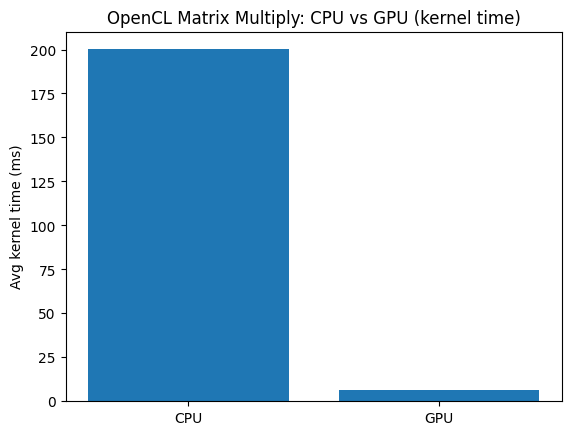

In [13]:
plt.figure()
plt.bar(df["device"], df["avg_kernel_ms"])
plt.ylabel("Avg kernel time (ms)")
plt.title("OpenCL Matrix Multiply: CPU vs GPU (kernel time)")
plt.show()


# Контрольные вопросы:
1. Какие основные типы памяти используются в OpenCL?

*   Global memory (глобальная): доступна всем work-item, самая большая, но относительно медленная
*   Local memory (локальная): общая для work-group, быстрее global, используется для тайлинга/кэширования
*   Private memory (приватная): регистры/локальные переменные одного work-item, самая быстрая
*   Constant memory (константная): read-only, кэшируемая (часто внутри global, но с отдельным режимом доступа)
2. Как настроить глобальную и локальную рабочую группу?

В OpenCL при запуске ядра нужно указать, сколько параллельных потоков (work-item) будет выполняться и как они будут объединяться в группы.

*   Global Work Size — это общее количество work-item, которые запускаются.
Например, если у нас вектор длины SIZE, то global size = SIZE.
А для матричного умножения global size можно задать как (N, K).
*   Local Work Size — это размер одной рабочей группы (work-group), то есть сколько work-item входит в одну группу.
Например, для одномерной задачи можно поставить 256, а для двумерной — например 16×16.

Эти параметры задаются при запуске ядра через функцию:сlEnqueueNDRangeKernel(...)

А внутри ядра каждый поток получает свой номер с помощью: get_global_id(dim)
и по этому индексу выполняет свою часть вычислений.

3. Чем отличается OpenCL от CUDA?
*   OpenCL — открытый стандарт, кросс-платформенный, работает на CPU/GPU разных производителей.
*   CUDA — технология NVIDIA, ориентирована на устройства NVIDIA и обычно проще для разработки под их GPU, но не кросс-платформенная.
4. Какие преимущества дает использование OpenCL?
*   Кросс-платформенность (разные производители и типы устройств).
*   Гибкость (единый подход к CPU/GPU).
*   Поддержка гетерогенных систем (можно использовать разные устройства в одной модели).
*   Масштабируемость при параллельных вычислениях.


